In [39]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier  # 随机森林分类器
from sklearn.model_selection import train_test_split  # 数据集分割
from sklearn.metrics import classification_report, accuracy_score  # 模型评估指标
from sklearn.feature_selection import mutual_info_classif  # 特征选择（信息增益）
import matplotlib.pyplot as plt  # 数据可视化

data_q4 = pd.read_excel('女胎检测数据.xlsx')
data_q4

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,Unnamed: 21,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康
0,1,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231119,1,13w+5,...,NaN,-0.016976,0.379614,0.392832,0.402970,0.024708,NaN,1,0,是
1,2,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231208,2,17w+1,...,NaN,-0.024409,0.377950,0.391176,0.399509,0.025608,NaN,1,0,是
2,3,B001,32,162.0,85.0,2023-08-06 00:00:00,自然受孕,20240101,3,19w+6,...,NaN,-0.016357,0.385021,0.397515,0.408611,0.024452,NaN,1,0,是
3,4,B001,32,162.0,86.0,2023-08-06 00:00:00,自然受孕,20240123,4,23w,...,NaN,-0.021307,0.376070,0.389126,0.397539,0.022412,NaN,1,0,是
4,5,B002,33,165.0,96.0,2023-02-15 00:00:00,自然受孕,20230519,1,12w+5,...,NaN,-0.000886,0.378697,0.391196,0.401632,0.022843,NaN,1,0,是
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,601,B146,34,164.0,90.0,2022-12-31 00:00:00,自然受孕,20230615,4,23w+1,...,NaN,-0.014243,0.381691,0.393509,0.402032,0.019539,T18,≥3,1,是
601,602,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230423,1,15w,...,NaN,-0.000855,0.382151,0.395193,0.406132,0.022342,NaN,≥3,1,是
602,603,B147,32,166.0,84.0,2023-01-08 00:00:00,自然受孕,20230513,2,15w+4,...,NaN,-0.006456,0.378540,0.391420,0.400972,0.027777,NaN,≥3,1,是
603,604,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230610,3,19w+4,...,NaN,-0.013719,0.379481,0.391826,0.401168,0.022127,NaN,≥3,1,是


In [40]:
# 新增怀孕时间（天）列
def week2day(week: str):
    try:
        w = 0
        d = 0
        if '+' in week:
            WAD = week.split("+")
            w = int(WAD[0].strip("w").strip())
            d = int(WAD[1].strip("d").strip())
        elif 'w' in week:
            w = int(week.strip('w').strip())
            d = 0
        elif 'd' in week:
            w = 0
            d = int(week.strip('d').strip())
        else:
            # 如果格式不符合预期，返回NaN或默认值
            return pd.NaT
        return 7*w+d
    except (ValueError, AttributeError):
        # 处理转换错误
        return pd.NaT
    
    
data_q4["怀孕时间"] = data_q4["检测孕周"].apply(week2day)
data_q4

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,X染色体浓度,13号染色体的GC含量,18号染色体的GC含量,21号染色体的GC含量,被过滤掉读段数的比例,染色体的非整倍体,怀孕次数,生产次数,胎儿是否健康,怀孕时间
0,1,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231119,1,13w+5,...,-0.016976,0.379614,0.392832,0.402970,0.024708,NaN,1,0,是,96
1,2,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231208,2,17w+1,...,-0.024409,0.377950,0.391176,0.399509,0.025608,NaN,1,0,是,120
2,3,B001,32,162.0,85.0,2023-08-06 00:00:00,自然受孕,20240101,3,19w+6,...,-0.016357,0.385021,0.397515,0.408611,0.024452,NaN,1,0,是,139
3,4,B001,32,162.0,86.0,2023-08-06 00:00:00,自然受孕,20240123,4,23w,...,-0.021307,0.376070,0.389126,0.397539,0.022412,NaN,1,0,是,161
4,5,B002,33,165.0,96.0,2023-02-15 00:00:00,自然受孕,20230519,1,12w+5,...,-0.000886,0.378697,0.391196,0.401632,0.022843,NaN,1,0,是,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,601,B146,34,164.0,90.0,2022-12-31 00:00:00,自然受孕,20230615,4,23w+1,...,-0.014243,0.381691,0.393509,0.402032,0.019539,T18,≥3,1,是,162
601,602,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230423,1,15w,...,-0.000855,0.382151,0.395193,0.406132,0.022342,NaN,≥3,1,是,105
602,603,B147,32,166.0,84.0,2023-01-08 00:00:00,自然受孕,20230513,2,15w+4,...,-0.006456,0.378540,0.391420,0.400972,0.027777,NaN,≥3,1,是,109
603,604,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230610,3,19w+4,...,-0.013719,0.379481,0.391826,0.401168,0.022127,NaN,≥3,1,是,137


In [41]:
new_columns = {
    'T13异常': np.nan,
    'T18异常': np.nan,
    'T21异常': np.nan,
    '二分类异常': np.nan,
    'T13T18异常': np.nan,
    'T13T21异常': np.nan,
    'T18T21异常': np.nan
}

# 使用 assign 方法批量添加空列
data_q4 = data_q4.assign(**new_columns)
data_q4

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,生产次数,胎儿是否健康,怀孕时间,T13异常,T18异常,T21异常,二分类异常,T13T18异常,T13T21异常,T18T21异常
0,1,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231119,1,13w+5,...,0,是,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231208,2,17w+1,...,0,是,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,B001,32,162.0,85.0,2023-08-06 00:00:00,自然受孕,20240101,3,19w+6,...,0,是,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,B001,32,162.0,86.0,2023-08-06 00:00:00,自然受孕,20240123,4,23w,...,0,是,161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,B002,33,165.0,96.0,2023-02-15 00:00:00,自然受孕,20230519,1,12w+5,...,0,是,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,601,B146,34,164.0,90.0,2022-12-31 00:00:00,自然受孕,20230615,4,23w+1,...,1,是,162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601,602,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230423,1,15w,...,1,是,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602,603,B147,32,166.0,84.0,2023-01-08 00:00:00,自然受孕,20230513,2,15w+4,...,1,是,109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603,604,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230610,3,19w+4,...,1,是,137,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# 先把空值填成空字符串，方便后面统一处理
data_q4['染色体的非整倍体'] = data_q4['染色体的非整倍体'].fillna('')

# 构造三个新列，默认 0
for col in ['T13异常', 'T18异常', 'T21异常']:
    data_q4[col] = 0

# 根据 AB 列内容打 1
data_q4.loc[data_q4['染色体的非整倍体'].str.contains('T13', na=False), 'T13异常'] = 1
data_q4.loc[data_q4['染色体的非整倍体'].str.contains('T18', na=False), 'T18异常'] = 1
data_q4.loc[data_q4['染色体的非整倍体'].str.contains('T21', na=False), 'T21异常'] = 1

# 更新“二分类异常”列
data_q4['二分类异常'] = np.where((data_q4['T13异常'] == 1) | (data_q4['T18异常'] == 1) | (data_q4['T21异常'] == 1), 1, 0)

# 更新“T13T18异常”列
data_q4['T13T18异常'] = np.where((data_q4['T13异常'] == 1) & (data_q4['T18异常'] == 1), 1, 0)

# 更新“T13T21异常”列
data_q4['T13T21异常'] = np.where((data_q4['T13异常'] == 1) & (data_q4['T21异常'] == 1), 1, 0)

# 更新“T18T21异常”列
data_q4['T18T21异常'] = np.where((data_q4['T18异常'] == 1) & (data_q4['T21异常'] == 1), 1, 0)

data_q4

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,生产次数,胎儿是否健康,怀孕时间,T13异常,T18异常,T21异常,二分类异常,T13T18异常,T13T21异常,T18T21异常
0,1,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231119,1,13w+5,...,0,是,96,0,0,0,0,0,0,0
1,2,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231208,2,17w+1,...,0,是,120,0,0,0,0,0,0,0
2,3,B001,32,162.0,85.0,2023-08-06 00:00:00,自然受孕,20240101,3,19w+6,...,0,是,139,0,0,0,0,0,0,0
3,4,B001,32,162.0,86.0,2023-08-06 00:00:00,自然受孕,20240123,4,23w,...,0,是,161,0,0,0,0,0,0,0
4,5,B002,33,165.0,96.0,2023-02-15 00:00:00,自然受孕,20230519,1,12w+5,...,0,是,89,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,601,B146,34,164.0,90.0,2022-12-31 00:00:00,自然受孕,20230615,4,23w+1,...,1,是,162,0,1,0,1,0,0,0
601,602,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230423,1,15w,...,1,是,105,0,0,0,0,0,0,0
602,603,B147,32,166.0,84.0,2023-01-08 00:00:00,自然受孕,20230513,2,15w+4,...,1,是,109,0,0,0,0,0,0,0
603,604,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230610,3,19w+4,...,1,是,137,0,0,0,0,0,0,0


In [43]:
# 定义特征列名列表（用于模型输入的变量）
features = [
     '检测抽血次数', '孕妇BMI', '在参考基因组上比对的比例',
    '重复读段的比例', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值',
    'X染色体的Z值', 'X染色体浓度', '13号染色体的GC含量', '18号染色体的GC含量', '怀孕时间']
# 删除任何特征列或目标列中包含缺失值的行
data_q4 = data_q4.dropna(subset=features)
data_q4

,序号,孕妇代码,年龄,身高,体重,末次月经,IVF妊娠,检测日期,检测抽血次数,检测孕周,...,生产次数,胎儿是否健康,怀孕时间,T13异常,T18异常,T21异常,二分类异常,T13T18异常,T13T21异常,T18T21异常
0,1,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231119,1,13w+5,...,0,是,96,0,0,0,0,0,0,0
1,2,B001,32,162.0,82.0,2023-08-06 00:00:00,自然受孕,20231208,2,17w+1,...,0,是,120,0,0,0,0,0,0,0
2,3,B001,32,162.0,85.0,2023-08-06 00:00:00,自然受孕,20240101,3,19w+6,...,0,是,139,0,0,0,0,0,0,0
3,4,B001,32,162.0,86.0,2023-08-06 00:00:00,自然受孕,20240123,4,23w,...,0,是,161,0,0,0,0,0,0,0
4,5,B002,33,165.0,96.0,2023-02-15 00:00:00,自然受孕,20230519,1,12w+5,...,0,是,89,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,601,B146,34,164.0,90.0,2022-12-31 00:00:00,自然受孕,20230615,4,23w+1,...,1,是,162,0,1,0,1,0,0,0
601,602,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230423,1,15w,...,1,是,105,0,0,0,0,0,0,0
602,603,B147,32,166.0,84.0,2023-01-08 00:00:00,自然受孕,20230513,2,15w+4,...,1,是,109,0,0,0,0,0,0,0
603,604,B147,32,166.0,86.0,2023-01-08 00:00:00,自然受孕,20230610,3,19w+4,...,1,是,137,0,0,0,0,0,0,0



模型评估报告:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       162
           1       1.00      0.20      0.33        20

    accuracy                           0.91       182
   macro avg       0.96      0.60      0.64       182
weighted avg       0.92      0.91      0.88       182

准确率: 0.9120879120879121
袋外分数: 0.8933649289099526


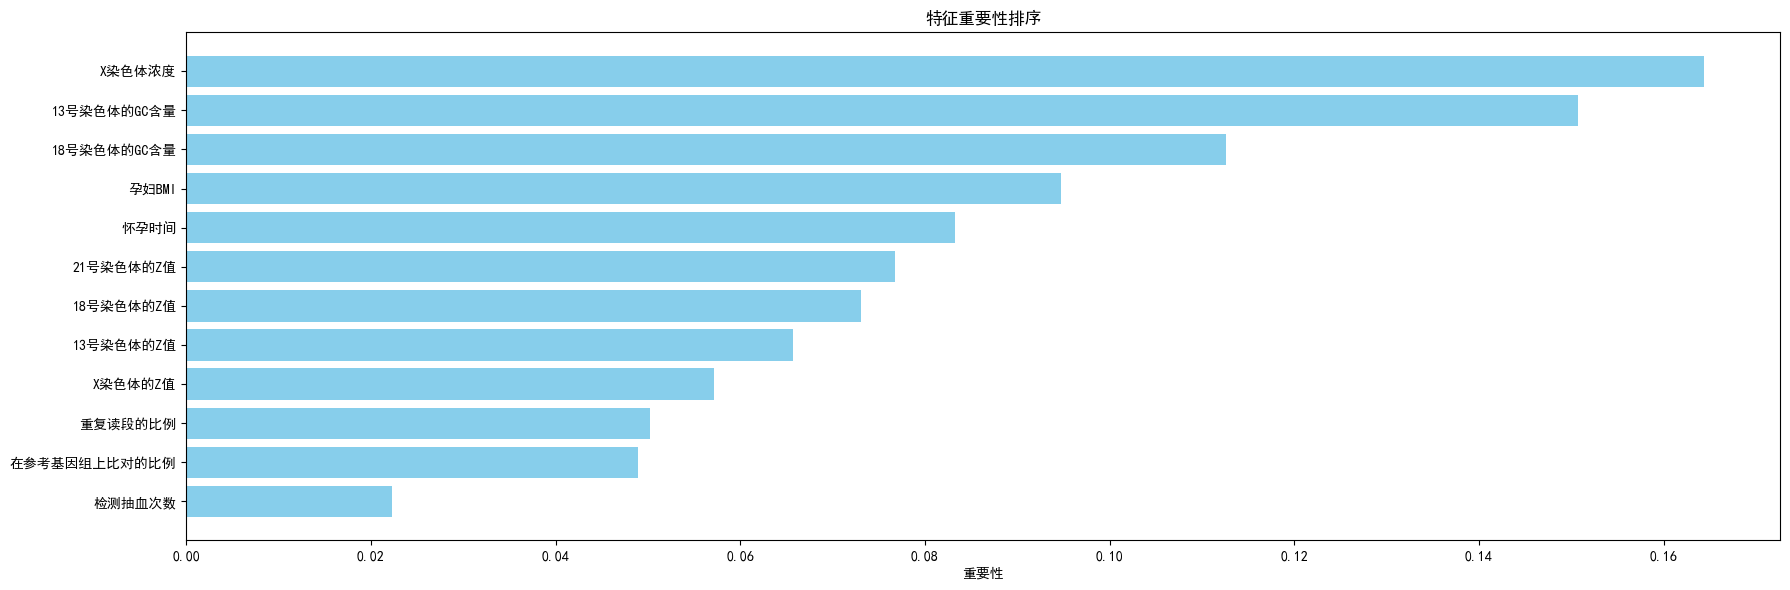

In [44]:
# 定义目标变量列名（第一种异常分类）
target1 = '二分类异常'

# 提取特征矩阵X（所有特征列）和目标向量y（目标列）
X = data_q4[features]
y1 = data_q4[target1]

# 将数据划分为训练集和测试集
X_train, X_test, y1_train, y1_test = train_test_split(
    X, y1,
    test_size=0.3,  # 测试集占30%
    random_state=42,  # 随机种子确保结果可复现
    stratify=y1  # 保持训练集和测试集中目标变量的类别比例相同
)

# 初始化随机森林分类器
rf1 = RandomForestClassifier(
    n_estimators=100,  # 森林中树的数量
    max_features='sqrt',  # 每棵树考虑的特征数
    bootstrap=True,  # 使用bootstrap采样构建每棵树
    oob_score=True,  # 计算袋外分数（out-of-bag score）
    random_state=42,  # 固定随机状态
    class_weight='balanced'  # 自动平衡类别权重
)

# 在训练集上训练模型
rf1.fit(X_train, y1_train)

# 在测试集上进行预测
y1_pred = rf.predict(X_test)

# 打印分类报告（包含精确度、召回率、F1分数等指标）
print("\n模型评估报告:")
print(classification_report(y1_test, y1_pred))

# 计算并打印准确率
print("准确率:", accuracy_score(y1_test, y1_pred))

# 打印袋外分数（OOB Score）- 随机森林特有的评估指标
print("袋外分数:", rf1.oob_score_)
def plot_feature_importances(rf):
    # 创建特征重要性DataFrame
    feature_importances = pd.DataFrame({
    'Feature': features,  # 特征名称
    'Importance': rf.feature_importances_  # 特征重要性得分
    }).sort_values(by='Importance')  # 按重要性排序

    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
    # 创建水平条形图展示特征重要性
    plt.figure(figsize=(18, 6))  # 设置图形大小
    plt.barh(
        feature_importances['Feature'],  # y轴：特征名称
        feature_importances['Importance'],  # x轴：重要性得分
        color='skyblue'  # 条形颜色
    )
    plt.xlabel('重要性')  # x轴标签
    plt.title('特征重要性排序')  # 图表标题
    plt.tight_layout()  # 自动调整子图参数
    plt.show()  # 显示图形

plot_feature_importances(rf1)